<h1><center><font color=darkcyan>  GARCH and stochastic volatility models </font></center></h1>

<h2><center><font color=darkorange> GARCH and stochastic volatility models </font></center></h2>
Many researchers (see the list of references below) recently suggest the existence of daily (high frequency) and lower frequency time-varying volatility in
real nancial series. In particular, mixed frequency data sampling (MIDAS)
models with multiplicative component GARCH models have been proposed
in the literature. To give a simple example of such models, assume a sequence
of daily log-returns ($r_t$) that follows
<br/>
$$r_t = \sqrt\tau_t * \epsilon_t$$
where $\tau_t$ is a low frequency volatility of the form
$$\tau_t = a + b * RV_{t - 1}; a > 0; b \geq 0; RV_t = \sum_{t=1}^{N} r_{t}^2$$
with $RV_t$ is a "realized volatilty" (of approximately one month if N = 22),
and
$$\epsilon_t = \sigma_t * \eta_t$$ 
is a unit-variance GARCH :
$$\sigma_t^2 = 1 - \alpha - \beta + \alpha * \epsilon_{t - 1}^2 + \beta * \sigma_{t - 1}^2$$

<br/>
<lu>
    <li><font color=darkblue> SOPGOUI MBEUKAM Lionel</font></li>
</lu>
<hr>

## Imports

In [1]:
import pandas as pd
import datetime
from sklearn.decomposition import PCA
import random
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from scipy import stats
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
sp = pd.read_csv("sp500.csv", delimiter=',', skipinitialspace=True,
                   quotechar='"', quoting=csv.QUOTE_MINIMAL)

In [3]:
cac = pd.read_csv("cac40.csv", delimiter=',', skipinitialspace=True,
                   quotechar='"', quoting=csv.QUOTE_MINIMAL)

In [9]:
sp = sp.set_index(pd.DatetimeIndex(sp['Date']))
sp = sp.drop('Date', axis=1)

cac = cac.set_index(pd.DatetimeIndex(cac['Date']))
cac = cac.drop('Date', axis=1)

In [10]:
sp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [11]:
cac.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,4294.049805,4311.000000,4224.339844,4252.290039,4252.290039,69809300.0
2015-01-05,4221.990234,4276.919922,4105.450195,4111.359863,4111.359863,137887700.0
2015-01-06,4129.890137,4151.410156,4076.159912,4083.500000,4083.500000,130814400.0
2015-01-07,4111.729980,4144.950195,4080.780029,4112.729980,4112.729980,121316600.0
2015-01-08,4176.160156,4270.109863,4163.629883,4260.189941,4260.189941,154417100.0


## Plot daily close prices

In [12]:
def plot_2(var, k = 0):
    plt.figure(1, figsize=(16,8))
    plt.subplot(2, 2, 1)
    plt.title('Moyenne des returns par période')
    plt.title('Price S&P 500')
    plt.ylabel(var)
    plt.xlabel('Date')
    plt.plot(sp[var][k:])
    plt.xticks(rotation=25)

    plt.subplot(2, 2,2)
    plt.title('Price CAC 40')
    plt.ylabel(var)
    plt.xlabel('Date')
    plt.plot(cac[var][k:])
    plt.xticks(rotation=25)
    plt.show()


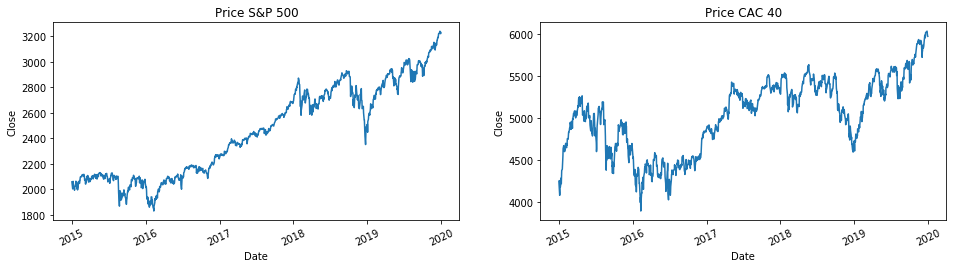

In [13]:
plot_2("Close")

## Compute and close daily log-returns

In [15]:
sp['LogReturn'] = np.log(1 + sp.Close.pct_change())
sp['r2'] = sp['LogReturn']**2

cac['LogReturn'] = np.log(1 + cac.Close.pct_change())
cac['r2'] = cac['LogReturn']**2

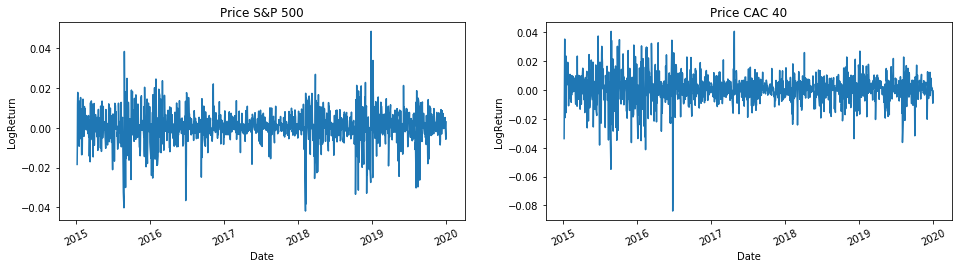

In [16]:
plot_2("LogReturn")

## Compute and plot N=22 realized volatility

In [17]:
def somme(data, deb, size):
    tmp = 0
    for i in range(deb, deb+size):
        tmp += data.iloc[i]
    return tmp

In [19]:
N = 22

In [20]:
tmp = np.array([somme(sp["r2"], np.max([0, i-N+1]), N) for i in range(sp.shape[0])])
sp['RV'] = tmp

tmp = np.array([somme(cac["r2"], np.max([0, i-N+1]), N) for i in range(cac.shape[0])])
cac['RV'] = tmp

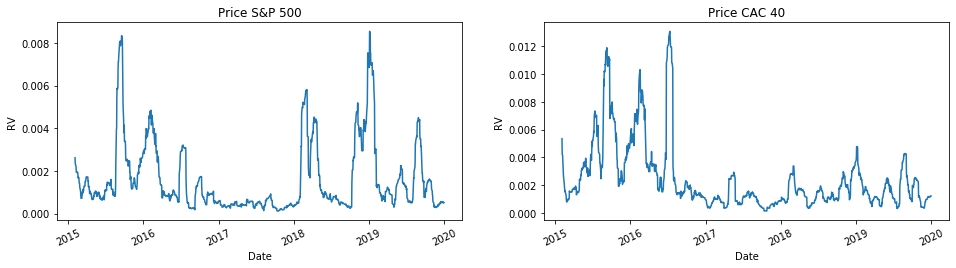

In [21]:
plot_2("RV")

## Optimize $\hat{L_n}(\theta)$ and get $\hat{\theta_n}$

In [32]:
#data = sp
data = cac

In [33]:
f_init = 1
n = data.shape[0]
def f_(f_prec, alpha, beta, r2, tau):
    return 1-alpha-beta + alpha*(r2 / tau) + beta* f_prec

def tau_(a, b, RV):
    return a + b * RV

def L(x):
    #print(x)
    a = x[0]
    b = x[1]
    alpha = x[2]
    beta = x[3]
    f = f_init
    tau = tau_(a, b, data.RV.iloc[N])
    l = np.log(f*tau) + data.r2.iloc[N] / (f*tau)
    for i in range(N+2, n):
        f = f_(f, alpha, beta, data.r2.iloc[i-1], tau)
        tau = tau_(a, b, data.RV.iloc[i-1])        
        l += (np.log(f*tau) + data.r2.iloc[i-1] / (f*tau))
        #print(i, " : ", l)
    return l/(n-N)

In [34]:
from scipy.optimize import minimize
x0 = np.array([0.3, 0.3, 0.2, 0.5])
res = minimize(L, x0, method='Nelder-Mead')

In [35]:
print(res.x)

[-3.16781688e-05  3.15967548e-01  9.99968977e-01 -1.12540967e-04]


## Compute and plot $\hat{\tau_t}$

In [36]:
data["tau"] = tau_(res.x[0], res.x[1], data["RV"])

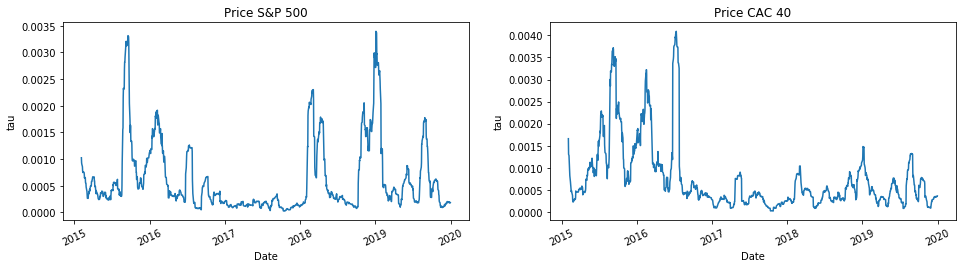

In [37]:
plot_2("tau")

## Compute and plot $\hat{\sigma_t}$

In [38]:
tmp = [0]*(N+1)
tmp.append(1)
for i in range(N+2,data.shape[0]):
    tmp.append(f_(tmp[i-1], res.x[2], res.x[3], data.r2[i-1], data.tau[i-1]))
    
data["f"] = np.sqrt(tmp)

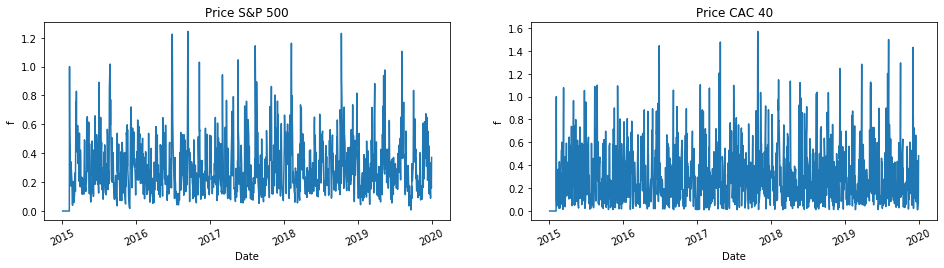

In [39]:
plot_2("f")

## Compute and plot $\hat{r_t}$ predited by the model

In [40]:
error = np.random.randn(data.shape[0])
data["rt"] = np.sqrt(data["f"]*data["tau"]) * error

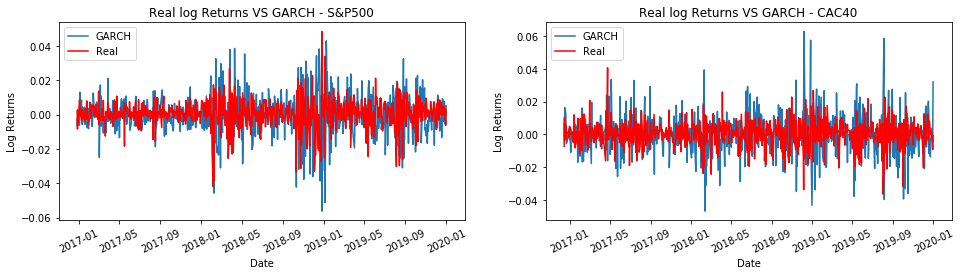

In [42]:
plt.figure(1, figsize=(16,8))
k = 500
plt.subplot(2, 2, 1)
plt.title('Real log Returns VS GARCH - S&P500')
plt.ylabel('Log Returns')
plt.xlabel('Date')
plt.plot(sp['rt'][k:], label="GARCH")
plt.plot(sp['LogReturn'][k:], "red", label="Real")
plt.xticks(rotation=25)
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Real log Returns VS GARCH - CAC40')
plt.ylabel('Log Returns')
plt.xlabel('Date')
plt.plot(cac['rt'][k:], label="GARCH")
plt.plot(cac['LogReturn'][k:], "red", label="Real")
plt.xticks(rotation=25)
plt.legend()

plt.show()

## End !